<a href="https://colab.research.google.com/github/peterphoenix/School-Projects/blob/master/Project_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project ANN LAB - BB01

Peter Phoenix - 2201735413

Richard Sudaryono A. - 2201771072 

# TODO:

nanti bagian ini dihapus sebelum dikumpul

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!wget "http://datasetprojectlabann.surge.sh/E202-COMP7117-TD01-00 - clustering.csv"
!wget "http://datasetprojectlabann.surge.sh/E202-COMP7117-TD01-00 - classification.csv"

--2020-06-12 03:40:35--  http://datasetprojectlabann.surge.sh/E202-COMP7117-TD01-00%20-%20clustering.csv
Resolving datasetprojectlabann.surge.sh (datasetprojectlabann.surge.sh)... 138.197.235.123
Connecting to datasetprojectlabann.surge.sh (datasetprojectlabann.surge.sh)|138.197.235.123|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-06-12 03:40:36 ERROR 404: Not Found.

--2020-06-12 03:40:38--  http://datasetprojectlabann.surge.sh/E202-COMP7117-TD01-00%20-%20classification.csv
Resolving datasetprojectlabann.surge.sh (datasetprojectlabann.surge.sh)... 138.197.235.123
Connecting to datasetprojectlabann.surge.sh (datasetprojectlabann.surge.sh)|138.197.235.123|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-06-12 03:40:38 ERROR 404: Not Found.



# yang bakal dikumpul

## clustering.py

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


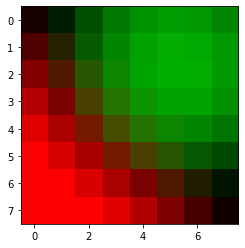

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

data_clustering = pd.read_csv('E202-COMP7117-TD01-00 - clustering.csv')
 
# Feature Selection
new_clustering = pd.DataFrame(columns = ['Special Day Rate', 'Visitor Type', 'Weekend', 'Product Related Duration', 'Exit Rates'])

new_clustering['Special Day Rate'] = data_clustering['SpecialDay'].map({'LOW': 0, 'NORMAL': 1, 'HIGH': 2})
new_clustering['Visitor Type'] = data_clustering['VisitorType'].map({'Other': 0, 'New_Visitor': 1, 'Returning_Visitor': 2})
new_clustering['Weekend'] = data_clustering['Weekend'].map({False: 0, True: 1})
new_clustering['Product Related Duration'] = data_clustering['ProductRelated_Duration']
new_clustering['Exit Rates'] = data_clustering['ExitRates']

# Feature Extraction

def calc_mean(dataset):
    return tf.reduce_mean(dataset, axis = 0)

def normalize_data(dataset, mean):
    return dataset - mean

def apply_pca(normalized_dataset, n):
    pca = PCA(n_components = n)
    pca = pca.fit(normalized_dataset)
    return pca.transform(normalized_dataset)

with tf.Session() as sess:
    clustering_mean = sess.run(calc_mean(new_clustering))
    
clustering_norm = normalize_data(new_clustering, clustering_mean)
clustering_pca = apply_pca(clustering_norm, 3)

class SOM:
    def __init__(self, width, height, input_dimension):
        self.width = width
        self.height = height
        self.input_dimension = input_dimension

        self.weight = tf.Variable(tf.random_normal([width * height, input_dimension]))
        self.input = tf.placeholder(tf.float32, [input_dimension])

        self.location = [tf.to_float([y,x]) for y in range(height) for x in range(width)]

        self.bmu = self.getBMU()

        self.update_weight = self.update_neigbours()

    def getBMU(self):
        square_distance = tf.square(self.input - self.weight)
        distance = tf.sqrt(tf.reduce_sum(square_distance, axis=1))

        bmu_index = tf.argmin(distance)

        bmu_position = tf.to_float([tf.div(bmu_index,self.width), tf.mod(bmu_index, self.width)])
        return bmu_position

    def update_neigbours(self):
        learning_rate = 0.8

        sigma = tf.to_float(tf.maximum(self.width, self.height) / 2)

        square_difference = tf.square(self.bmu - self.location)
        distance = tf.sqrt(tf.reduce_sum(square_difference,axis=1))

        NS = tf.exp(tf.div(tf.negative(tf.square(distance)), 2 * tf.square(sigma)))

        rate = NS * learning_rate

        rate_stacked = tf.stack([tf.tile(tf.slice(rate,[i],[1]), [self.input_dimension]) 
            for i in range(self.width * self.height)])

        new_weight = self.weight + rate_stacked * (self.input - self.weight)

        return tf.assign(self.weight, new_weight)

    def train(self, dataset, epoch):

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(epoch+1):
                for data in dataset:
                    dictionary = {
                        self.input : data
                    }

                    sess.run(self.update_weight,feed_dict=dictionary)

            location = sess.run(self.location)
            weight = sess.run(self.weight)

            clusters = [[] for i in range(self.height)]

            for i, loc in enumerate(location):
                clusters[int(loc[0])].append(weight[i])

            self.clusters = clusters

input_dimension = len(clustering_pca[0])
epoch = 5000

som = SOM(8, 8, input_dimension)

som.train(clustering_pca,epoch)
plt.imshow(som.clusters)
plt.show()

## classification.py

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler

data_classification = pd.read_csv('E202-COMP7117-TD01-00 - classification.csv')

# Feature Selection
new_classification = pd.DataFrame(columns = ['Volatile Acidity', 'Chlorides', 'Free Sulfur Dioxide', 'Total Sulfur Dioxide', 'Density', 'pH', 'Sulphates', 'Alcohol'])
new_classification['Volatile Acidity'] = data_classification['volatile acidity']
new_classification['Chlorides'] = data_classification['chlorides']
new_classification['Free Sulfur Dioxide'] = data_classification['free sulfur dioxide'].map({'Low': 1, 'Medium': 2, 'High': 3}).fillna(0).astype(int)
new_classification['Total Sulfur Dioxide'] = data_classification['total sulfur dioxide']
new_classification['Density'] = data_classification['density'].map({'Very High': 0, 'Low':1, 'Medium': 2, 'High': 3})
new_classification['pH'] = data_classification['pH'].map({'Very Acidic': 1, 'Normal': 2, 'Very Basic': 3}).fillna(0).astype(int)
new_classification['Sulphates'] = data_classification['sulphates']
new_classification['Alcohol'] = data_classification['alcohol']

# Feature Extraction
def calc_mean(dataset):
    return tf.reduce_mean(dataset, axis = 0)

def normalize_data(dataset, mean):
    return dataset - mean

def apply_pca(normalized_dataset, n):
    pca = PCA(n_components = n)
    pca = pca.fit(normalized_dataset)
    return pca.transform(normalized_dataset)

with tf.Session() as sess:
    classification_mean = sess.run(calc_mean(new_classification))

classification_norm = normalize_data(new_classification, classification_mean)
classification_pca = apply_pca(classification_norm, 4)

input_data = MinMaxScaler().fit_transform(classification_pca)
output_data = OneHotEncoder(sparse=False).fit_transform(data_classification[['quality']])

# Training
layer = {
    "input": 4,
    "hidden": 30,
    "output": 5
}

weight = {
    "input_to_hidden": tf.Variable(tf.random_normal([layer["input"], layer["hidden"]])),
    "hidden_to_output": tf.Variable(tf.random_normal([layer["hidden"], layer["output"]]))
}

bias = {
    "input_to_hidden": tf.Variable(tf.random_normal([layer["hidden"]])),
    "hidden_to_output": tf.Variable(tf.random_normal([layer["output"]]))
}

input_placeholder = tf.placeholder(tf.float32, [None, layer["input"]])
output_placeholder = tf.placeholder(tf.float32, [None, layer["output"]])

def feed_forward(data):
    y = tf.matmul(data, weight["input_to_hidden"]) + bias["input_to_hidden"]
    y2 = tf.nn.sigmoid(y)

    z = tf.matmul(y2, weight["hidden_to_output"]) + bias["hidden_to_output"]
    z2 = tf.nn.sigmoid(z)

    return z2

output = feed_forward(input_placeholder)

epoch = 5000
alpha = 0.9

loss = tf.reduce_mean(0.5 * (output_placeholder - output) ** 2)
optimizer = tf.train.GradientDescentOptimizer(alpha)
train = optimizer.minimize(loss)
saver = tf.train.Saver()

prev_validation_error = 0

input_train, input_validation, output_train, output_validation = train_test_split(input_data, output_data, test_size=0.2)
input_train, input_test, output_train, output_test = train_test_split(input_train, output_train, test_size=0.125)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for i in range(1, epoch+1):

        train_dict = {
            input_placeholder: input_train,
            output_placeholder: output_train
        }

        sess.run(train, feed_dict=train_dict)
        error_train = sess.run(loss, feed_dict=train_dict)

        if i % 100 == 0:
            print("Epoch = {}, Current Error = {}".format(i, error_train))

        if i % 500 == 0:
            validation_dict = {
                input_placeholder: input_validation,
                output_placeholder: output_validation
            }

            error_validation = sess.run(loss, feed_dict=validation_dict)

            print("Epoch = {}, Validation Error = {}".format(i, error_validation))

            if i == 500 or error_validation < prev_validation_error:
                prev_validation_error = error_validation
                saver.save(sess, "model/model.ckpt")

    accuracy = tf.equal(tf.argmax(output_placeholder, axis=1), tf.argmax(output, axis=1))
    accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

    test_dict = {
        input_placeholder: input_test,
        output_placeholder: output_test
    }

    print("Accuracy = {}%".format(sess.run(accuracy, feed_dict=test_dict) * 100))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch = 100, Current Error = 0.08317404240369797
Epoch = 200, Current Error = 0.08114657551050186
Epoch = 300, Current Error = 0.06328898668289185
Epoch = 400, Current Error = 0.0631011575460434
Epoch = 500, Current Error = 0.06295284628868103
Epoch = 500, Validation Error = 0.06476254761219025
Epoch = 600, Current Error = 0.06283047795295715
Epoch = 700, Current Error = 0.06272728741168976
Epoch = 800, Current Error = 0.0626390278339386
Epoch = 900, Current Error = 0.06256256997585297
Epoch = 1000, Current Error = 0.062495626509189606
Epoch = 1000, Validation Error = 0.06409168988466263
Epoch = 1100, Current Error = 0.06243639066815376
Epoch = 1200, Current Error = 0.06238348409533501
Epoch = 1300, Current Error = 0.0623357780277729
Epoch = 1400, Current Error = 0.06229243054986
Epoch = 1500, Current Error = 0.06225277855992317
Epoch = 1500, Validation Error = 0.06367412209510803
Epoch = 1600

# Import Library

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    accuracy = tf.equal(tf.argmax(output_placeholder, axis=1), tf.argmax(output, axis=1))
    accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

    test_dict = {
        input_placeholder: input_test,
        output_placeholder: output_test
    }

    print(sess.run(tf.argmax(output_placeholder, axis=1), feed_dict=test_dict))
    print(sess.run(tf.argmax(output, axis=1), feed_dict=test_dict))
    print(sess.run(tf.equal(tf.argmax(output_placeholder, axis=1), tf.argmax(output, axis=1)), feed_dict=test_dict))
    print(sess.run(accuracy, feed_dict=test_dict))
    # print("Accuracy = {}%".format(sess.run(accuracy, feed_dict=test_dict) * 100))

[4 0 2 3 2 2 2 4 0 3 0 0 1 2 0 0 2 0 2 0 2 1 2 2 2 0 0 0 0 0 0 0 1 0 0 2 2
 2 0 0 2 2 2 0 2 0 3 0 0 3 0 2 3 0 0 0 0 2 0 0 3 2 2 3 0 2 2 2 0 2 2 2 0 3
 0 3 2 2 0 2 0 0 2 2 0 3 0 0 0 0 0 0 0 2 2 2 0 0 3 2 4 0 0 3 0 2 0 0 2 0 2
 0 0 2 0 2 0 2 2 2 2 0 0 1 3 2 0 0 3 2 2 0 2 0 2 2 0 2 0 2 0 0 2 2 1 0 0 2
 2 3 0 0 0 3 3 4 0 0 0 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[False  True False False False False False False  True False  True  True
 False False  True  True False  True False  True False False False False
 False  True  True  True  True  True  True  True False  True  True False
 False False  True  True False False False  True False  True False  True
  True False  True False False  True  True  True  True F

# Clustering (Self-Organizing Map)

In [ ]:
data_clustering = pd.read_csv('E202-COMP7117-TD01-00 - clustering.csv')
print(data_clustering)
 
# Feature Selection
new_clustering = pd.DataFrame(columns = ['Special Day Rate', 'Visitor Type', 'Weekend', 'Product Related Duration', 'Exit Rates'])
 
new_clustering['Special Day Rate'] = data_clustering['SpecialDay'].map({'LOW': 0, 'NORMAL': 1, 'HIGH': 2})
new_clustering['Visitor Type'] = data_clustering['VisitorType'].map({'Other': 0, 'New_Visitor': 1, 'Returning_Visitor': 2})
new_clustering['Weekend'] = data_clustering['Weekend'].map({False: 0, True: 1})
new_clustering['Product Related Duration'] = data_clustering['ProductRelated_Duration']
new_clustering['Exit Rates'] = data_clustering['ExitRates']
 
print(new_clustering)

      Administrative  Administrative_Duration  ...  Weekend  Revenue
0                  0                      0.0  ...    False    False
1                  0                      0.0  ...    False    False
2                  0                     -1.0  ...    False    False
3                  0                      0.0  ...    False    False
4                  0                      0.0  ...     True    False
...              ...                      ...  ...      ...      ...
3627               0                      0.0  ...    False    False
3628               0                      0.0  ...    False    False
3629               0                      0.0  ...    False    False
3630               3                     18.0  ...    False    False
3631               0                      0.0  ...    False    False

[3632 rows x 18 columns]
      Special Day Rate  Visitor Type  ...  Product Related Duration  Exit Rates
0                    0             2  ...                         

In [ ]:
# Feature Extraction

def calc_mean(dataset):
    return tf.reduce_mean(dataset, axis = 0)

def normalize_data(dataset, mean):
    return dataset - mean

def apply_pca(normalized_dataset, n):
    pca = PCA(n_components = n)
    pca = pca.fit(normalized_dataset)
    return pca.transform(normalized_dataset)

with tf.Session() as sess:
    clustering_mean = sess.run(calc_mean(new_clustering))
    
clustering_norm = normalize_data(new_clustering, clustering_mean)

# scaler = StandardScaler()
# scaler.fit(new_clustering)
# clustering_norm = scaler.transform(new_clustering)

clustering_pca = apply_pca(clustering_norm, 3)

print(clustering_pca)

[[ 2.27066853 -0.64400383 -0.54780557]
 [ 2.27066853 -0.64400383 -0.54780557]
 [ 2.27066853 -0.64400383 -0.54780557]
 ...
 [-0.66133867  0.39225062 -1.1310385 ]
 [ 1.51046058 -1.34116664 -0.00537215]
 [ 0.01647496  0.89114655 -1.66497783]]


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
0
1
2
3
4
5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


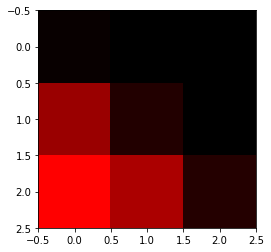

In [ ]:
class SOM:
    def __init__(self, width, height, input_dimension):
        self.width = width
        self.height = height
        self.input_dimension = input_dimension

        self.weight = tf.Variable(tf.random_normal([width * height, input_dimension]))
        self.input = tf.placeholder(tf.float32, [input_dimension])

        self.location = [tf.to_float([y,x]) for y in range(height) for x in range(width)]

        self.bmu = self.getBMU()

        self.update_weight = self.update_neigbours()

    def getBMU(self):
        square_distance = tf.square(self.input - self.weight)
        distance = tf.sqrt(tf.reduce_sum(square_distance, axis=1))

        bmu_index = tf.argmin(distance)

        bmu_position = tf.to_float([tf.div(bmu_index,self.width), tf.mod(bmu_index, self.width)])
        return bmu_position

    def update_neigbours(self):
        learning_rate = 0.1

        sigma = tf.to_float(tf.maximum(self.width, self.height) / 2)

        square_difference = tf.square(self.bmu - self.location)
        distance = tf.sqrt(tf.reduce_sum(square_difference,axis=1))

        NS = tf.exp(tf.div(tf.negative(tf.square(distance)), 2 * tf.square(sigma)))

        rate = NS * learning_rate

        rate_stacked = tf.stack([tf.tile(tf.slice(rate,[i],[1]), [self.input_dimension]) 
            for i in range(self.width * self.height)])

        new_weight = self.weight + rate_stacked * (self.input - self.weight)

        return tf.assign(self.weight, new_weight)

    def train(self, dataset, epoch):

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(epoch+1):
                if (i%1 == 0) :
                  print(i)
                for data in dataset:
                    dictionary = {
                        self.input : data
                    }

                    sess.run(self.update_weight,feed_dict=dictionary)

            location = sess.run(self.location)
            weight = sess.run(self.weight)

            clusters = [[] for i in range(self.height)]

            for i, loc in enumerate(location):
                clusters[int(loc[0])].append(weight[i])

            self.clusters = clusters



input_dimension = len(clustering_pca[0])
# epoch = 5000
epoch = 5 # TODO: epochnya balikin ke 5000

som = SOM(3,3,input_dimension)

som.train(clustering_pca,epoch)
plt.imshow(som.clusters)
plt.show()


# Classification (yg sdh rapi)

In [ ]:
data_classification = pd.read_csv('E202-COMP7117-TD01-00 - classification.csv')


# Feature Selection
new_classification = pd.DataFrame(columns = ['Volatile Acidity', 'Chlorides', 'Free Sulfur Dioxide', 'Total Sulfur Dioxide', 'Density', 'pH', 'Sulphates', 'Alcohol'])
new_classification['Volatile Acidity'] = data_classification['volatile acidity']
new_classification['Chlorides'] = data_classification['chlorides']
new_classification['Free Sulfur Dioxide'] = data_classification['free sulfur dioxide'].map({'Low': 1, 'Medium': 2, 'High': 3}).fillna(0).astype(int)
new_classification['Total Sulfur Dioxide'] = data_classification['total sulfur dioxide']
new_classification['Density'] = data_classification['density'].map({'Very High': 0, 'Low':1, 'Medium': 2, 'High': 3})
new_classification['pH'] = data_classification['pH'].map({'Very Acidic': 1, 'Normal': 2, 'Very Basic': 3}).fillna(0).astype(int)
new_classification['Sulphates'] = data_classification['sulphates']
new_classification['Alcohol'] = data_classification['alcohol']


# Feature Extraction
with tf.Session() as sess:
    classification_mean = sess.run(calc_mean(new_classification))
classification_norm = normalize_data(new_classification, classification_mean)

classification_pca = apply_pca(classification_norm, 4)

# input_data = MinMaxScaler().fit_transform(classification_pca)
input_data = MinMaxScaler().fit_transform(new_classification)
output_data = OneHotEncoder(sparse=False).fit_transform(data_classification[['quality']])


# Training
layer = {
    # "input": 4,
    "input": 8,
    "hidden": 30,
    "output": 5
}

weight = {
    "input_to_hidden": tf.Variable(tf.random_normal([layer["input"], layer["hidden"]])),
    "hidden_to_output": tf.Variable(tf.random_normal([layer["hidden"], layer["output"]]))
}

bias = {
    "input_to_hidden": tf.Variable(tf.random_normal([layer["hidden"]])),
    "hidden_to_output": tf.Variable(tf.random_normal([layer["output"]]))
}

input_placeholder = tf.placeholder(tf.float32, [None, layer["input"]])
output_placeholder = tf.placeholder(tf.float32, [None, layer["output"]])

def feed_forward(data):
    y = tf.matmul(data, weight["input_to_hidden"]) + bias["input_to_hidden"]
    y2 = tf.nn.sigmoid(y)

    z = tf.matmul(y2, weight["hidden_to_output"]) + bias["hidden_to_output"]
    z2 = tf.nn.sigmoid(z)

    return z2

output = feed_forward(input_placeholder)

epoch = 5000
alpha = 0.9

loss = tf.reduce_mean(0.5 * (output_placeholder - output) ** 2)
optimizer = tf.train.GradientDescentOptimizer(alpha)
train = optimizer.minimize(loss)
saver = tf.train.Saver()

prev_validation_error = 0

input_train, input_validation, output_train, output_validation = train_test_split(input_data, output_data, test_size=0.2)
input_train, input_test, output_train, output_test = train_test_split(input_train, output_train, test_size=0.125)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for i in range(1, epoch+1):

        train_dict = {
            input_placeholder: input_train,
            output_placeholder: output_train
        }

        sess.run(train, feed_dict=train_dict)
        error_train = sess.run(loss, feed_dict=train_dict)

        if i % 100 == 0:
            print("Epoch = {}, Current Error = {}".format(i, error_train))

        if i % 500 == 0:
            validation_dict = {
                input_placeholder: input_validation,
                output_placeholder: output_validation
            }

            error_validation = sess.run(loss, feed_dict=validation_dict)

            print("Epoch = {}, Validation Error = {}".format(i, error_validation))

            if i == 500 or error_validation < prev_validation_error:
                prev_validation_error = error_validation
                saver.save(sess, "model/model.ckpt")

    accuracy = tf.equal(tf.argmax(output_placeholder, axis=1), tf.argmax(output, axis=1))
    accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

    test_dict = {
        input_placeholder: input_test,
        output_placeholder: output_test
    }

    print("Accuracy = {}%".format(sess.run(accuracy, feed_dict=test_dict) * 100))


NameError: ignored

# Classification (coba-coba pake library)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
 
# new_classification2 = StandardScaler().fit_transform(new_classification)
# classification_pca = apply_pca(new_classification2, 4)

# input_data = MinMaxScaler().fit_transform(classification_pca)

# X = input_data
X = classification_norm.values
y = output_data
 
folds = 5
kf = KFold(n_splits=folds)
kf.get_n_splits(X)
 
knn = [0, 0, 0, 0]
rf = [0, 0, 0, 0]
 
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
 
    modelknn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
    modelrf = RandomForestClassifier(max_depth=None,random_state=None).fit(X_train,y_train)
 
    predictknn = modelknn.predict(X_test)
    predictrf = modelrf.predict(X_test)

    # print(predictknn, y_test)
 
    knn[0] += accuracy_score(y_test, predictknn) * 100
    knn[1] += precision_score(y_test, predictknn, average='weighted') * 100
    knn[2] += recall_score(y_test, predictknn, average='weighted') * 100
    knn[3] += f1_score(y_test, predictknn, average='weighted')
 
    rf[0] += accuracy_score(y_test, predictrf) * 100
    rf[1] += precision_score(y_test, predictrf, average='weighted') * 100
    rf[2] += recall_score(y_test, predictrf, average='weighted') * 100
    rf[3] += f1_score(y_test, predictrf, average='weighted')
 
print("KNN:")
print("Accuracy: ", knn[0] / folds)
print("Precision: ", knn[1] / folds)
print("Recall: ", knn[2] / folds)
print("F1 Score: ", knn[3] / folds)

print("\nRF:")
print("Accuracy: ", rf[0] / folds)
print("Precision: ", rf[1] / folds)
print("Recall: ", rf[2] / folds)
print("F1 Score: ", rf[3] / folds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

KNN:
Accuracy:  41.52703761755485
Precision:  47.72433655240053
Recall:  41.52703761755485
F1 Score:  0.437437170864518

RF:
Accuracy:  44.593260188087775
Precision:  58.44177824712473
Recall:  44.593260188087775
F1 Score:  0.4952370111512039


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Classification (kotor)

In [ ]:
data_classification = pd.read_csv('E202-COMP7117-TD01-00 - classification.csv')

# Feature Selection
new_classification = pd.DataFrame(columns = ['Volatile Acidity', 'Chlorides', 'Free Sulfur Dioxide', 'Total Sulfur Dioxide', 'Density', 'pH', 'Sulphates', 'Alcohol'])
new_classification['Volatile Acidity'] = data_classification['volatile acidity']
new_classification['Chlorides'] = data_classification['chlorides']
new_classification['Free Sulfur Dioxide'] = data_classification['free sulfur dioxide'].map({'Low': 1, 'Medium': 2, 'High': 3}).fillna(0).astype(int)
new_classification['Total Sulfur Dioxide'] = data_classification['total sulfur dioxide']
new_classification['Density'] = data_classification['density'].map({'Very High': 0, 'Low':1, 'Medium': 2, 'High': 3})
new_classification['pH'] = data_classification['pH'].map({'Very Acidic': 1, 'Normal': 2, 'Very Basic': 3}).fillna(0).astype(int)
new_classification['Sulphates'] = data_classification['sulphates']
new_classification['Alcohol'] = data_classification['alcohol']

# Output
#ini outputnya ga di suruh di map sih tapi seharusnya di map kan ya?
# new_classification['Quality'] = data_classification['quality'].map({'Fair': 1, 'Decent': 2, 'Fine': 3, 'Good': 4, 'Great': 5})

print(new_classification)
print(new_classification.isna())

NameError: ignored

In [ ]:
# Feature Extraction

with tf.Session() as sess:
    classification_mean = sess.run(calc_mean(new_classification))
classification_norm = normalize_data(new_classification, classification_mean)

# scaler.fit(new_classification)
# classification_norm = scaler.transform(new_classification)

classification_pca = apply_pca(classification_norm, 4)

# print(classification_pca)
# print(classification_pca.shape)

input_data = MinMaxScaler().fit_transform(classification_pca)
output_data = OneHotEncoder(sparse=False).fit_transform(data_classification[['quality']])

print(input_data)
# print(input_data.shape)

[[1.04529625e-10 2.68649490e-03 9.89339135e-02 8.62583854e-01]
 [1.46341485e-10 2.53367939e-03 2.15590945e-01 6.31969093e-01]
 [1.46341480e-10 2.55323989e-03 1.69587958e-01 9.48752533e-01]
 ...
 [2.71777014e-10 2.47124871e-03 1.20169828e-01 4.32851342e-01]
 [1.88153322e-10 2.54789515e-03 1.34302659e-01 2.81493787e-01]
 [2.71777015e-10 2.28538746e-03 1.27162769e-01 5.72157888e-01]]


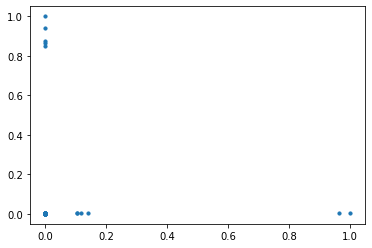

In [ ]:
classification_pca2 = apply_pca(classification_norm, 2)
input_data2 = MinMaxScaler().fit_transform(classification_pca2)
# print(input_data2)

import matplotlib.pyplot as plt 
  
x = [i[0] for i in input_data2]
y = [i[1] for i in input_data2]

plt.scatter(x, y, s=10)
plt.show() 


In [ ]:
layer = {
    "input": 4,
    "hidden": 30,
    "output": 5
}

weight = {
    "input_to_hidden": tf.Variable(tf.random_normal([layer["input"], layer["hidden"]])),
    "hidden_to_output": tf.Variable(tf.random_normal([layer["hidden"], layer["output"]]))
}

bias = {
    "input_to_hidden": tf.Variable(tf.random_normal([layer["hidden"]])),
    "hidden_to_output": tf.Variable(tf.random_normal([layer["output"]]))
}

input_placeholder = tf.placeholder(tf.float32, [None, layer["input"]])
output_placeholder = tf.placeholder(tf.float32, [None, layer["output"]])

def feed_forward(data):

    y = tf.matmul(data, weight["input_to_hidden"]) + bias["input_to_hidden"]
    y2 = tf.nn.sigmoid(y)

    z = tf.matmul(y2, weight["hidden_to_output"]) + bias["hidden_to_output"]
    z2 = tf.nn.sigmoid(z)

    return z2

# weight = {
#     "input_to_output": tf.Variable(tf.random_normal([layer["input"], layer["output"]])),
# }

# bias = {
#     "input_to_output": tf.Variable(tf.random_normal([layer["output"]])),
# }

# input_placeholder = tf.placeholder(tf.float32, [None, layer["input"]])
# output_placeholder = tf.placeholder(tf.float32, [None, layer["output"]])

# def feed_forward(data):

#     y = tf.matmul(data, weight["input_to_output"]) + bias["input_to_output"]
#     y2 = tf.nn.sigmoid(y)

#     return y2

output = feed_forward(input_placeholder)

epoch = 5000
alpha = 0.9

loss = tf.reduce_mean(0.5 * (output_placeholder - output) ** 2)
optimizer = tf.train.GradientDescentOptimizer(alpha)
train = optimizer.minimize(loss)
saver = tf.train.Saver()

prev_validation_error = 0

# semoga ini splitnya bener wkwkw
input_train, input_validation, output_train, output_validation = train_test_split(input_data, output_data, test_size=0.2)
input_train, input_test, output_train, output_test = train_test_split(input_train, output_train, test_size=0.125)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for i in range(1, epoch+1):

        train_dict = {
            input_placeholder: input_train,
            output_placeholder: output_train
        }

        sess.run(train, feed_dict=train_dict)
        error_train = sess.run(loss, feed_dict=train_dict)

        if i % 100 == 0:
            print("Current Error = {}, Epoch = {}".format(error_train, i))

        if i % 500 == 0:
            validation_dict = {
                input_placeholder: input_validation,
                output_placeholder: output_validation
            }

            error_validation = sess.run(loss, feed_dict=validation_dict)

            print("Validation Current Error = {}, Epoch = {}".format(error_validation, i))

            if i == 500:
                prev_validation_error = error_validation
            elif error_validation < prev_validation_error:
                prev_validation_error = error_validation
                saver.save(sess, "model/model.ckpt")

    accuracy = tf.equal(tf.argmax(output_placeholder, axis=1), tf.argmax(output, axis=1))
    accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

    test_dict = {
        input_placeholder: input_test,
        output_placeholder: output_test
    }

    print("Accuracy = {}%".format(sess.run(accuracy, feed_dict=test_dict) * 100))


Current Error = 0.08155761659145355, Epoch = 100
Current Error = 0.08051542937755585, Epoch = 200
Current Error = 0.07843859493732452, Epoch = 300
Current Error = 0.0640651136636734, Epoch = 400
Current Error = 0.06383925676345825, Epoch = 500
Validation Current Error = 0.0649474710226059, Epoch = 500
Current Error = 0.06364346295595169, Epoch = 600
Current Error = 0.06347059458494186, Epoch = 700
Current Error = 0.06331638991832733, Epoch = 800
Current Error = 0.063177689909935, Epoch = 900
Current Error = 0.06305203586816788, Epoch = 1000
Validation Current Error = 0.06410297006368637, Epoch = 1000
Current Error = 0.06293745338916779, Epoch = 1100
Current Error = 0.06283239275217056, Epoch = 1200
Current Error = 0.06273555755615234, Epoch = 1300
Current Error = 0.06264598667621613, Epoch = 1400
Current Error = 0.06256275624036789, Epoch = 1500
Validation Current Error = 0.06363091617822647, Epoch = 1500
Current Error = 0.062485285103321075, Epoch = 1600
Current Error = 0.062412947416